In [1]:
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LinearRegression, BayesianRidge

In [50]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
# from eda import DataMangler
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("white")

In [2]:
PATH = Path('../data/houseprice/')

In [3]:
dftrain = pd.read_csv(PATH/'train.csv')
dftest = pd.read_csv(PATH/'test.csv')

In [4]:
df = pd.concat([dftrain, dftest], axis=0)

In [12]:
len(df) == len(dftrain) + len(dftest)

True

In [32]:
class DataMangler:
    def __init__(self, data):        
        self.data = data if isinstance(data, pd.DataFrame) else pd.DataFrame(data)
        self.stats = {}
        self.categorical_columns = []
        self.categorical_dims = {}

    def drop(self, col):
        if not isinstance(col, list):
            col = [col]

        try:
            for c in col:
                self.data = self.data.drop(c, axis=1)
                del self.stats[c]
        except (IndexError, KeyError) as e:
            print(f'{e}: Invalid index or key')

    def eda(self):
        print(f"Data:\n\
                Shape: \t{self.data.shape}\n\
                ")
        for col in self.data.columns:
            self.stats[col] = [self.data[col].nunique(),
                               self.data[col].unique()[:10],
                               self.data[col].min() if self.data[col].dtype != 'object' else '-',
                               self.data[col].max() if self.data[col].dtype != 'object' else '-',
                               self.data[col].mean() if self.data[col].dtype != 'object' else '-',
                               self.data[col].median() if self.data[col].dtype != 'object' else '-',
                               self.data[col].dtype,
                               self.data[col].isnull().sum(),
                               round(100*self.data[col].isnull().sum()/self.data.shape[0], 2)
                              ]
        return pd.DataFrame.from_dict(self.stats, orient='index', columns=['Num Unique', 'First 10 unique', 'Min', 'Max', 'Mean', 'Median', 'Type', 'Missing total', 'Missing relative']).sort_values('Missing relative', ascending=False)

    def impute(self, columns, value):
        columns = columns if isinstance(self.data, list) else list(columns)
        for col in columns:
            self.data[col].fillna(value, inplace=True)    
    
    def iterative(self, columns, estimator):        
        ii = IterativeImputer(estimator=estimator(), max_iter=10, random_state=0)
        res = pd.DataFrame(ii.fit_transform(pd.DataFrame(self.data[columns])), columns=columns)
        for col in res.columns:
            self.data[col] = res[col]
    
    def plot(self):
        for col in self.data.columns:
            sns.histplot(self.data[col], color="dodgerblue", label="Compact")          

    def process(self):
        for col in self.data.columns:
            if self.data[col].dtype=='object' or self.data[col].nunique() < 200:
                self.data[col].fillna('missing', inplace=True)
                l_enc = LabelEncoder()
                l_enc.fit(self.data[col].astype(str))
                self.data[col] = l_enc.transform(self.data[col].astype(str))        
                self.categorical_columns.append(col)
                self.categorical_dims[col] = len(l_enc.classes_)
            if self.data[col].nunique() >= 200:        
                self.data.fillna(self.data[col].mean(), inplace=True)

In [135]:
dftrain['PoolQC'].fillna('NA', inplace=True)
dftrain['Fence'].fillna('NA', inplace=True)
dftrain['BsmtQual'].fillna('NA', inplace=True)
dftrain['BsmtCond'].fillna('NA', inplace=True)
dftrain['BsmtExposure'].fillna('NA', inplace=True)
dftrain['BsmtFinType1'].fillna('NA', inplace=True)
dftrain['BsmtFinType2'].fillna('NA', inplace=True)
dftrain['Electrical'].fillna('Missing', inplace=True)
dftrain['FireplaceQu'].fillna('NA', inplace=True)
dftrain['GarageFinish'].fillna('NA', inplace=True)
dftrain['GarageQual'].fillna('NA', inplace=True)
dftrain['GarageCond'].fillna('NA', inplace=True)
dftrain['GarageType'].fillna('NA', inplace=True)
dftrain['GarageYrBlt'].fillna(0, inplace=True)
dftrain['MasVnrArea'].fillna(0., inplace=True)
dftrain['MasVnrType'].fillna('None', inplace=True)
dftrain['MiscFeature'].fillna('NA', inplace=True)

In [33]:
dm = DataMangler(df)

In [41]:
dm.eda()

Data:
                Shape: 	(2919, 80)
                


,Num Unique,First 10 unique,Min,Max,Mean,Median,Type,Missing total,Missing relative
SalePrice,663,"[208500.0, 181500.0, 223500.0, 140000.0, 25000...",34900,755000,180921,163000,float64,1459,49.98
BsmtFullBath,4,"[1.0, 0.0, 2.0, 3.0, nan]",0,3,0.429894,0,float64,2,0.07
BsmtHalfBath,3,"[0.0, 1.0, 2.0, nan]",0,2,0.0613644,0,float64,2,0.07
GarageArea,603,"[548.0, 460.0, 608.0, 642.0, 836.0, 480.0, 636...",0,1488,472.875,480,float64,1,0.03
TotalBsmtSF,1058,"[856.0, 1262.0, 920.0, 756.0, 1145.0, 796.0, 1...",0,6110,1051.78,989.5,float64,1,0.03
BsmtUnfSF,1135,"[150.0, 284.0, 434.0, 540.0, 490.0, 64.0, 317....",0,2336,560.772,467,float64,1,0.03
BsmtFinSF2,272,"[0.0, 32.0, 668.0, 486.0, 93.0, 491.0, 506.0, ...",0,1526,49.5822,0,float64,1,0.03
BsmtFinSF1,991,"[706.0, 978.0, 486.0, 216.0, 655.0, 732.0, 136...",0,5644,441.423,368.5,float64,1,0.03
KitchenQual,5,"[Gd, TA, Ex, Fa, NA]",-,-,-,-,object,0,0.00
FireplaceQu,6,"[NA, TA, Gd, Fa, Ex, Po]",-,-,-,-,object,0,0.00


In [35]:
dm.drop('Id')

In [36]:
dm.impute([x for x in df.columns if dftrain[x].dtype == 'object'], 'NA')

In [40]:
dm.impute(["GarageCars"], 0)
dm.impute(["GarageYrBlt"], 0)
dm.impute(["MasVnrArea"], 0)
dm.impute(["BsmtHalfBath"], 0)

In [38]:
dm.iterative(['LotFrontage', 'LotArea'], BayesianRidge)

In [15]:
import numpy as np

In [54]:
len(dm.data[(dm.data['BsmtHalfBath']==0) & (dm.data['BsmtFullBath']==0)])

1550

<AxesSubplot:xlabel='BsmtFullBath', ylabel='BsmtHalfBath'>

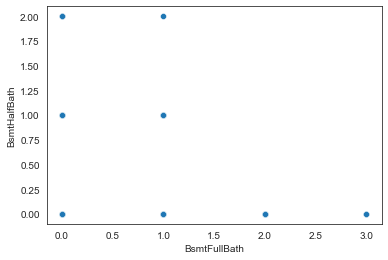

In [46]:
sns.scatterplot(x=dm.data['BsmtFullBath'], y=dm.data['BsmtHalfBath'])

<AxesSubplot:ylabel='Count'>

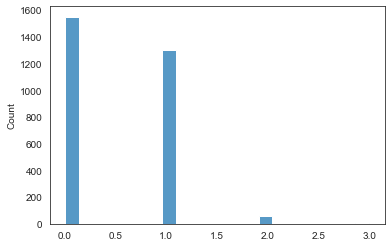

In [55]:
sns.histplot(dm.data['BsmtFullBath'] + dm.data['BsmtHalfBath'])

### Regression Imputation

<AxesSubplot:xlabel='LotArea', ylabel='LotFrontage'>

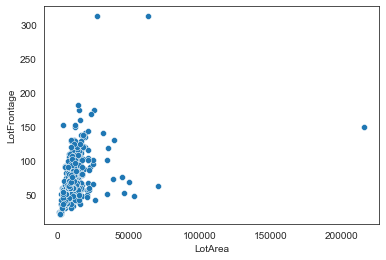

In [95]:
#sns.histplot(dftrain['GarageType'].fillna('Missing'), color='dodgerblue')
#sns.histplot(dftrain['GarageYrBlt'], color='red')
sns.scatterplot(x=dftrain['LotArea'], y=dftrain['LotFrontage'])

In [97]:
df.mean()

LotArea        10516.828082
LotFrontage       70.049958
dtype: float64

In [16]:
regdf = df[(df['LotFrontage'].isna()==False) & (df['LotArea'] < 200000)]

In [93]:
y = np.array(regdf['LotFrontage']).reshape(-1, 1)
X = np.array(regdf['LotArea']).reshape(-1, 1)
reg = LinearRegression().fit(X, y)

In [92]:
y = np.array(df['LotFrontage']).reshape(-1, 1)
X = np.array(df['LotArea']).reshape(-1, 1)
# reg = LinearRegression().fit(X, y)

In [94]:
reg.score(X, y), reg.intercept_

(0.2888128132759462, array([45.81603234]))

In [19]:
reg.predict(np.array(10382).reshape(-1, 1))

array([[71.46930356]])

<AxesSubplot:xlabel='LotFrontage', ylabel='LotArea'>

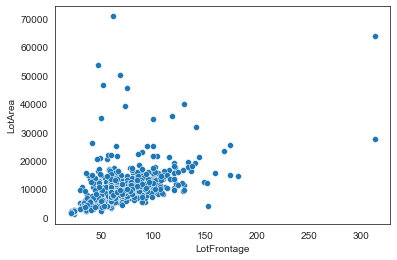

In [138]:
sns.scatterplot(x=tdpf['LotFrontage'], y=tdpf['LotArea'])

In [124]:
tempdf

,LotFrontage,LotArea
0,65.0,8450
1,80.0,9600
2,68.0,11250
3,60.0,9550
4,84.0,14260
5,85.0,14115
6,75.0,10084
7,NaN,10382
8,51.0,6120
9,50.0,7420


In [87]:
[print(i, v) for i, v in enumerate(y)]

0 [65.]
1 [80.]
2 [68.]
3 [60.]
4 [84.]
5 [85.]
6 [75.]
7 [51.]
8 [50.]
9 [70.]
10 [85.]
11 [91.]
12 [51.]
13 [72.]
14 [66.]
15 [70.]
16 [101.]
17 [57.]
18 [75.]
19 [44.]
20 [110.]
21 [60.]
22 [98.]
23 [47.]
24 [60.]
25 [50.]
26 [85.]
27 [70.]
28 [60.]
29 [108.]
30 [112.]
31 [74.]
32 [68.]
33 [65.]
34 [84.]
35 [115.]
36 [70.]
37 [61.]
38 [48.]
39 [84.]
40 [33.]
41 [66.]
42 [52.]
43 [110.]
44 [68.]
45 [60.]
46 [100.]
47 [24.]
48 [89.]
49 [66.]
50 [60.]
51 [63.]
52 [60.]
53 [44.]
54 [50.]
55 [76.]
56 [72.]
57 [47.]
58 [81.]
59 [95.]
60 [69.]
61 [74.]
62 [85.]
63 [60.]
64 [21.]
65 [50.]
66 [72.]
67 [60.]
68 [100.]
69 [32.]
70 [78.]
71 [80.]
72 [121.]
73 [122.]
74 [40.]
75 [105.]
76 [60.]
77 [60.]
78 [85.]
79 [80.]
80 [60.]
81 [69.]
82 [78.]
83 [73.]
84 [85.]
85 [77.]
86 [77.]
87 [64.]
88 [94.]
89 [75.]
90 [60.]
91 [50.]
92 [85.]
93 [105.]
94 [75.]
95 [77.]
96 [61.]
97 [34.]
98 [74.]
99 [90.]
100 [65.]
101 [50.]
102 [75.]
103 [55.]
104 [48.]
105 [60.]
106 [55.]
107 [69.]
108 [69.]
109 [88.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [59]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [88]:
lr = LinearRegression()

In [89]:
imp = IterativeImputer(estimator=lr, sample_posterior=True, max_iter=1, random_state=0)
imp.fit(X, y)

IterativeImputer(estimator=LinearRegression(), max_iter=1, random_state=0,
                 sample_posterior=True)

In [90]:
y_imp = imp.transform(y)

In [91]:
len(y_imp)

1200

In [82]:
y_imp.dtype

dtype('float64')

In [85]:
[print(i, x) for i, x in enumerate(y_imp)]

0 [65.]
1 [80.]
2 [68.]
3 [60.]
4 [84.]
5 [85.]
6 [75.]
7 [10516.82808219]
8 [51.]
9 [50.]
10 [70.]
11 [85.]
12 [10516.82808219]
13 [91.]
14 [10516.82808219]
15 [51.]
16 [10516.82808219]
17 [72.]
18 [66.]
19 [70.]
20 [101.]
21 [57.]
22 [75.]
23 [44.]
24 [10516.82808219]
25 [110.]
26 [60.]
27 [98.]
28 [47.]
29 [60.]
30 [50.]
31 [10516.82808219]
32 [85.]
33 [70.]
34 [60.]
35 [108.]
36 [112.]
37 [74.]
38 [68.]
39 [65.]
40 [84.]
41 [115.]
42 [10516.82808219]
43 [10516.82808219]
44 [70.]
45 [61.]
46 [48.]
47 [84.]
48 [33.]
49 [66.]
50 [10516.82808219]
51 [52.]
52 [110.]
53 [68.]
54 [60.]
55 [100.]
56 [24.]
57 [89.]
58 [66.]
59 [60.]
60 [63.]
61 [60.]
62 [44.]
63 [50.]
64 [10516.82808219]
65 [76.]
66 [10516.82808219]
67 [72.]
68 [47.]
69 [81.]
70 [95.]
71 [69.]
72 [74.]
73 [85.]
74 [60.]
75 [21.]
76 [10516.82808219]
77 [50.]
78 [72.]
79 [60.]
80 [100.]
81 [32.]
82 [78.]
83 [80.]
84 [10516.82808219]
85 [121.]
86 [122.]
87 [40.]
88 [105.]
89 [60.]
90 [60.]
91 [85.]
92 [80.]
93 [60.]
94 [69.]
9

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
dftrain[dftrain.isna().any(axis=1)]

In [130]:
dfgarage=pd.concat([dftrain['GarageYrBlt'].fillna('0000'), dftrain['GarageType']], axis=1)

In [131]:
dfgarage[dfgarage.isna().any(axis=1)]

,GarageYrBlt,GarageType
39,0000,NaN
48,0000,NaN
78,0000,NaN
88,0000,NaN
89,0000,NaN
99,0000,NaN
108,0000,NaN
125,0000,NaN
127,0000,NaN
140,0000,NaN


<AxesSubplot:xlabel='LotFrontage', ylabel='Count'>

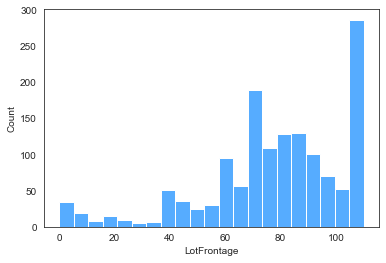

In [56]:
# plt.figure(figsize=(5,3), dpi = 100)
sns.histplot(dftrain['LotFrontage'], color="dodgerblue")

In [274]:
dm.eda()

Data:
                Shape: 	(1460, 80)
                
'MSSubClass':
                  Num Unique: 		15
                  First 10 Unique: 	[ 60  20  70  50 190  45  90 120  30  85]
                  Type: 		int64
                  Missing total 	0
                  Missing relative: 	0.0%
                  
'MSZoning':
                  Num Unique: 		5
                  First 10 Unique: 	['RL' 'RM' 'C (all)' 'FV' 'RH']
                  Type: 		object
                  Missing total 	0
                  Missing relative: 	0.0%
                  
'LotFrontage':
                  Num Unique: 		110
                  First 10 Unique: 	[65. 80. 68. 60. 84. 85. 75. nan 51. 50.]
                  Type: 		float64
                  Missing total 	259
                  Missing relative: 	17.74%
                  
'LotArea':
                  Num Unique: 		1073
                  First 10 Unique: 	[ 8450  9600 11250  9550 14260 14115 10084 10382  6120  7420]
                  Type: 		int64
   

In [ ]:
dm.plot()